Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script

In [1]:
#Descargamos la libreria de transformers que usaremos para descargar el modelo como su respectivo tokenizador
!pip  install transformers --quiet
!pip install Datasets --quiet
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet

In [2]:
#from transformers import AutoModelForSequenceClassification
#from transformers import TFDistilBertForSequenceClassification
#from transformers import TextClassificationPipeline

# Import other modules
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive  #Montador de drive
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset



In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task2']
df = df.rename(columns = {"task1": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexist
1,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [5]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexist'],[0, 1])

In [6]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
# Y revisamos como ha quedado el dataframe:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",1
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


In [7]:
!pip install pysentimiento

In [8]:
from pysentimiento.preprocessing import preprocess_tweet

In [9]:
df['text'].apply(preprocess_tweet)

0        Nadie te va a tratar tan bien como un hombre q...
1        @usuario Que rica putita obediente, afortunado...
2        @usuario Yo lo hice a los 18 años por la carre...
3        las cosas q sueño son indicios de que yo enrea...
4        Pero a la niña le gustó desde que lo vió, así ...
                               ...                        
11324    @usuario @usuario @usuario Disgustas a todos c...
11325    ¿Cómo estás, una mujer adulta que es literalme...
11326    Otro buscador de oro que busca ganar dinero co...
11327    Tenemos otra primera vez!! Tan feliz de ver a ...
11328    Cuando Simps &amp; Beta puede ejecutar sistema...
Name: text, Length: 11329, dtype: object

## 2.1 - Separamos el dataset en varios conjuntos (Train, Validación y Test)

In [10]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [11]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [12]:
#Lo convertimos en un solo dataset:

TWS = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

TWS = TWS.remove_columns(["__index_level_0__"])

In [13]:
TWS

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

In [14]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['Sexista','No_Sexista']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'Sexista', '1': 'No_Sexista'}, {'Sexista': '0', 'No_Sexista': '1'})

# 3.Descarga del modelo y su tokenizador



In [15]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "pysentimiento/robertuito-base-uncased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=128, truncation = True)

In [17]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
TWS_Encoded = TWS.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [18]:
TWS_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [19]:
#Necesitamos que los objetos sean de tipo torch
TWS_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [20]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

### 3.1.1 Métricas:

In [22]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [24]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [25]:
# Generamos un objeto Trainer para el entrenamiento:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = TWS_Encoded["train"],
  eval_dataset = TWS_Encoded["val"],
  tokenizer = tokenizer)

In [26]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
#5.Entrenamos nuestro modelo:
trainer.train()

{'loss': 0.5437, 'grad_norm': 9.01936149597168, 'learning_rate': 1.7057958223006767e-05, 'epoch': 0.44130626654898497}
{'loss': 0.4912, 'grad_norm': 13.801779747009277, 'learning_rate': 1.4115916446013535e-05, 'epoch': 0.8826125330979699}
{'eval_loss': 0.45797672867774963, 'eval_accuracy': 0.8075904677846425, 'eval_f1': 0.8072679802634811, 'eval_runtime': 7.7226, 'eval_samples_per_second': 146.713, 'eval_steps_per_second': 18.388, 'epoch': 1.0}
{'loss': 0.3742, 'grad_norm': 5.841438293457031, 'learning_rate': 1.1173874669020302e-05, 'epoch': 1.323918799646955}
{'loss': 0.3329, 'grad_norm': 18.439708709716797, 'learning_rate': 8.231832892027067e-06, 'epoch': 1.7652250661959399}
{'eval_loss': 0.5929690003395081, 'eval_accuracy': 0.8084730803177406, 'eval_f1': 0.8080406432433224, 'eval_runtime': 7.8637, 'eval_samples_per_second': 144.08, 'eval_steps_per_second': 18.058, 'epoch': 2.0}
{'loss': 0.2772, 'grad_norm': 20.33987808227539, 'learning_rate': 5.2897911150338345e-06, 'epoch': 2.20653

TrainOutput(global_step=3399, training_loss=0.3517807671237462, metrics={'train_runtime': 763.4732, 'train_samples_per_second': 35.612, 'train_steps_per_second': 4.452, 'train_loss': 0.3517807671237462, 'epoch': 3.0})

# Matriz de Confusión

In [28]:
preds_output = trainer.predict(TWS_Encoded["val"])

In [29]:
preds_output.metrics

{'test_loss': 0.45797672867774963,
 'test_accuracy': 0.8075904677846425,
 'test_f1': 0.8072679802634811,
 'test_runtime': 7.2883,
 'test_samples_per_second': 155.456,
 'test_steps_per_second': 19.483}

Text(0.5, 1.0, 'Matriz de confusión')

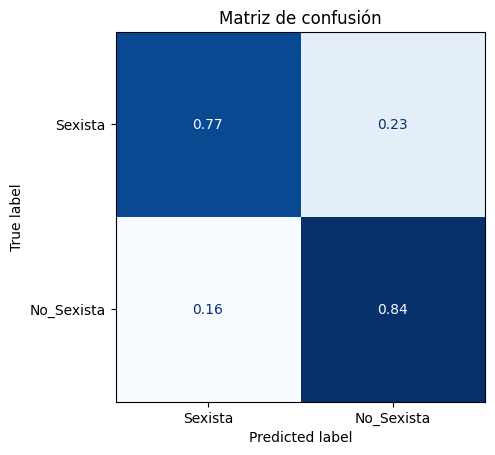

In [30]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["val"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

In [31]:
preds_output = trainer.predict(TWS_Encoded["test"])
preds_output.metrics



{'test_loss': 0.441238671541214,
 'test_accuracy': 0.7925860547219771,
 'test_f1': 0.792274525367055,
 'test_runtime': 7.1672,
 'test_samples_per_second': 158.082,
 'test_steps_per_second': 19.813}

Text(0.5, 1.0, 'Matriz de confusión')

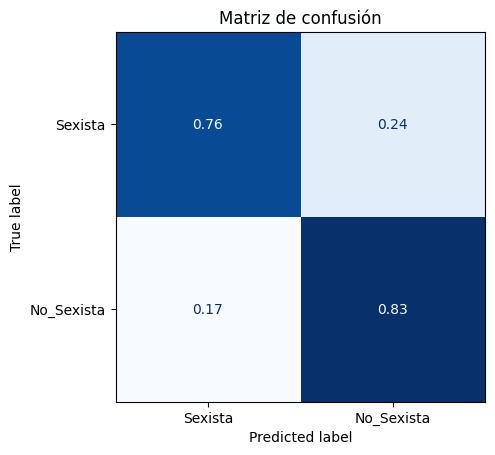

In [32]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["test"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

# Análisis del validation loss

In [33]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [34]:
TWS_Encoded["val"] = TWS_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [35]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [36]:
TWS_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = TWS_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [37]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
33,Sodomizar el sábado es maravilloso. Necesito a alguien(s) con quien sodomizar. https://t.co/j4UB1rHyBW,No_Sexista,Sexista,3.995220
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,No_Sexista,Sexista,3.783635
43,"Sí, sabemos lo borracho que era y lo que sigue siendo Killary, esperando a que su hígado se entregue.",No_Sexista,Sexista,3.629012
149,"https://t.co/pBzAmUNOO3Esta noticia me rompió el corazón. Piensa mi amigo, y si te pasara a ti o a algún ser querido seguirias siendo un pagafantas? Razón del porqué el #MeToo es una aberración",No_Sexista,Sexista,3.445459
342,@Sniper64286433 Todavía no. Hasta ahora sólo el MeToo Soy una tarjeta de víctima,No_Sexista,Sexista,3.438641
494,"""Ya me divertí""""Ya no quiero juegos""Siempre es lo mismo. El alfa primero, luego el beta con dinero. #MGTOW https://t.co/Oie3CKFvuV",No_Sexista,Sexista,3.376631
179,"#NoEsBromaY como si no fuera suficiente, tendrá que pagar una pensión alimenticia ...https://t.co/5fYh13p2WO",No_Sexista,Sexista,3.369725
256,"@milifiru @Julieta01029688 @Mauro_lpv @AmericaTV @A24COM No es todo solamente un tema de si los docentes esto o aquello, simia. Podés aprovechar un rato para no repetir tu sermón de mojigata. En las escuelas también hay alumnos.",No_Sexista,Sexista,3.161027
778,"¡Epítome de la hipocresía! La propia Cynthia ha presentado cargos contra el ex ministro del interior, pero este feminazi no la defiende. Probablemente porque:Cynthia no es una mujer a sus ojos o su mentalidad líbilda se niega a creer que RM podría hacer tal cosa#patética https://t.co/jNiIAIBfe6",Sexista,No_Sexista,3.109731
434,http://www.abc.es/espana/comunidad-valenciana/abci-manada-argelina-nueva-agresion-sexual-grupo-chica-alicante-201804161330_noticia.html,No_Sexista,Sexista,3.091036


In [38]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
# Ordena y muestra las primeras 10 filas
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
905,"Es seguro decir que 2020 fue un año de gran importancia histórica. ¡Gracias por compartir la esperanza que nos dio Jesucristo para ayudar a estos hombres, mujeres y niños a hacer sus propias historias! Disfrute de nuestro Informe Anual de 2020 a continuación. #HistoryInTheMakinghttps://t.co/33UoegDbZ5 https://t.co/NzTleNfLTv",Sexista,Sexista,0.006543
1019,Quito merece ser lo que fue. Recuperémoste la libertad y el trabajo para rescatar a la ciudad del abandono y la desidia. La @CorteConstEcu debe devolver a lo s quiteños sus derechos. #TrabajoYLibertad #DerechosYTrabajo https://t.co/qIue7KS0Gh,Sexista,Sexista,0.007438
187,"¡ EL COMPROMISO DE HACER MEJOR !Hoy se celebra el día Internacional de Voluntariado, es por ello que quiero saludar muy afectuosamente a todos los hombres y mujeres, que forman parte de las ONG's de la Provincia, que trabajan en la emergencia. https://t.co/YD8lXuDDBG",Sexista,Sexista,0.007455
1120,"""No hay suficientes palabras para agradecer a nuestros galantes hombres y mujeres uniformados, los militares que siguen haciendo sacrificios para que muchos de nosotros disfrutemos y expresemos nuestras libertades en sus diversas formas y formas.""#OurBoysAreBack https://t.co/IWWQOOZFgM",Sexista,Sexista,0.007832
484,@danieldessinger @StevePieczenik (1 de 2) Él lo dio el 4 de diciembre....Vi a Jesús y a un soldado de pie uno al lado del otro en la cima de esta gran colina.Ambos mirando hacia mí y mirando hacia la hermosa luz.Jesús era un hombre enorme.Viento soplaba su túnica y su pelo.Pero yo estaba muy lejos mirándolos al fondo de la colina.,Sexista,Sexista,0.007833
393,Resulta que hoy es el día de la juventud y no me queda más que felicitar al único que lo merece. Feliz día Gai! que la llama de tu juventud nunca se apague :),Sexista,Sexista,0.008413
820,"Si sales y haces que las cosas buenas sucedan, llenarás de esperanza al mundo y a tú mismo – Barack Obama¿Y si lo intentas?Atrévete, visítanos en https://t.co/QLH9voSqjV#Sanaccion #BarackObama #bueno #esperanza #mundo #Felicidad #Iluminación #Empoderamiento #crecimiento https://t.co/4YArmCNvr7",Sexista,Sexista,0.008456
239,"Gracias por compartir, abriste heridas que uno piensa ya están cerradas. #Yositecreo https://t.co/aZ7MePPQTO",Sexista,Sexista,0.008967
77,"Popeye' el cachorro puede ser fuerte, pero tiene Wellesley y Dover primeros respondedores para agradecer por sacarlo del agua helada del río Charles. https://t.co/O8cn4HCkJp",Sexista,Sexista,0.009186
531,"Permítanme decir un rápido gracias a la madre de Ezequías por esta libra de chocolate. hezekiah realmente me vuelve loco en el trabajo, pero como un niño de 5 años tengo que perdonarlo y ser amable",Sexista,Sexista,0.009226


In [39]:
model.save_pretrained(
  os.path.join(path_model, 'Twitter/twhin-finetuned-detección-sexismo'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'Twitter/twhin-finetuned-detección-sexismo'))

('/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/tokenizer_config.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/special_tokens_map.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/tokenizer.json')